# Convert OpenSN data to name,host,type,x,y,z,t,lum

Data downloaded from The Open Supernova Catalog https://sne.space on Aug. 20, 2019

In [2]:
import pandas as pd
import numpy as np
from astropy import units
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import WMAP9
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('OpenSNCat.csv')
#select the ones that have all the data we need
#In the end, I want z, but sonce there are multiple z values for some sources, 
# I think I will just use the luminosity distance and convert below
df = df.loc[(df['R.A.'].notnull()) & \
              (df['Dec.'].notnull()) & \
              (df['dL (Mpc)'].notnull()) & \
              (df['Disc. Date'].notnull()) & \
              (df['Mmax'].notnull())]
df

,Name,Disc. Date,Mmax,Host Name,R.A.,Dec.,z,dL (Mpc),Type
0,SN1987A,1987/02/24,-16.300,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.989...","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",0.0430,II Pec
1,SN2011fe,2011/08/24,-18.280,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05....","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:2...",0.000804,3.5600,Ia
2,SN2003dh,2003/03/31,-26.823,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.009,10:44:50...","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:1...",0.1685,836.4300,Ic BL
3,CSS141118:092034+504148,2016/04/22,-19.300,SDSS J092034.44+504148.7,"09:20:34.300,09:20:34.38,09:20:34.26,09:20:34.32","+50:41:46.60,+50:41:47.7,+50:41:48.4,+50:41:46.68",0.0344,156.2000,II P
4,SN1993J,1993/03/28,-17.400,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.001,09:55:2...","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01...",-0.000113,2.9000,IIb
...,...,...,...,...,...,...,...,...,...
57778,PS1-11ex,2011,-19.000,NaN,08:40:45.84,+43:48:00.72,0.58,3490.0000,Ia?
57812,PS1-11r,2011,-19.000,NaN,10:01:11.52,+01:34:31.44,0.4,2200.0000,Ia?
57842,PS1-11yh,2011/05/24,-17.930,NaN,"14:11:11.466,14:11:11.52","+51:59:12.63,+51:59:12.48","0.146,0.146",714.8000,II P
63595,SN185A,185/12/07,-16.000,Milky Way,"14:43:00,14:35:55,14:43:30.000","-62:30,-60:36,-62:28:00.00",NaN,0.0025,Ia


I will have to iterate through the rows, since some coords have multiple entries, and some dates are bad

In [ ]:
x = []
y = []
z = []
t = []

log10lum = []
name = []
host = []
tpe = []

#for datetime
fmt = '%Y/%m/%d'

N = 1e10
for index, row in df.iterrows():
    bad = False
    
    #there are still some dates that cause errors (e.g., 185/12/07/)
    date = str(row['Disc. Date'])
    pos = date.find(',')
    fmt0 = fmt
    if (pos != -1):    
        date = row['Disc. Date'][0:pos]
    pos1 = date.find('/')
    pos2 = date.rfind('/')
    if (pos1 == -1):
        fmt0 = '%Y'
    if (pos1 != -1 and pos2 == pos1):
        fmt0 = '%Y/%m/'
    if (fmt0 == fmt):
        val1 = int(date[0:pos1])
        if (val1 <= 12):
            fmt0 = '%m/%d/%Y'
        if (val1 > 12 and val1 < 1800):
            bad = True

    if (not bad):
        dt = datetime.datetime.strptime(date, fmt0) 
        t.append(dt.year + dt.month/12. + dt.day/365.24)
        
        ra = row['R.A.']
        pos = str(ra).find(',')
        if (pos != -1):    
            ra = row['R.A.'][0:pos]

        dec = row['Dec.']
        pos = str(dec).find(',')
        if (pos != -1):    
            dec = row['Dec.'][0:pos]

        d = row['dL (Mpc)']*units.Mpc
        #convert to comoving distance
        cosmoz = Distance(d).z
        
        c1 = SkyCoord(ra, dec, unit=(units.hourangle, units.deg), distance=WMAP9.comoving_distance(cosmoz)).galactic.cartesian

        x.append(c1.x.to(units.Mpc).value)
        y.append(c1.y.to(units.Mpc).value)
        z.append(c1.z.to(units.Mpc).value)

        log10lum.append(0.4*(4.74 - row['Mmax']))

        name.append(row['Name'])
        host.append(row['Host Name'])
        tpe.append(row['Type'])
        
    if (index > N):
        break
    

1885.7132114043734 2019.6748804439092


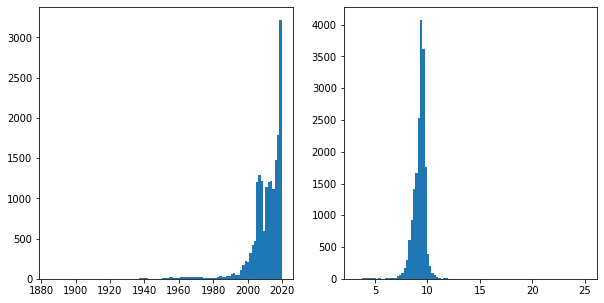

In [4]:
print(min(t), max(t))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
_ = ax1.hist(t,bins=100)
_ = ax2.hist(log10lum,bins=100)

### Write this to a new csv file

In [4]:
print(len(name), len(host), len(type), len(x), len(y), len(z), len(t))
data = {'name':np.array(name),
        'host':np.array(host),
        'type':np.array(tpe),
        'x':np.array(x),
        'y':np.array(y),
        'z':np.array(z),
        't':np.array(t),
        'log10lum':np.array(log10lum)}
pd.DataFrame(data).to_csv('OpenSNCatConverted.csv', index=False)

18201 18201 18201 18201 18201 18201 18201


In [13]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print(x)

In [18]:
unique(tpe)

II Pec
Ia
Ic BL
II P
IIb
IIn
II-P/L
Ia Pec
II
Ic
Ia-91T
Ib
Ibn
SLSN-I
TDE
Ib Pec
Ia-02cx
Ib/c
nan
IIn-pec/LBV
II P Pec
LBV to IIn
Ia-91bg
SLSN
SLSN-II
Ic Pec
IIn?
Ia Pec?
BL-Ic
Candidate
Ia CSM
Ic/Ic-BL
SLSN-R
SLSN-II?
IIn/Ibn
Ia-HV
II L
AGN
I
Ia?
Ca-rich
Ibn/IIbn
II-Pp.
Super-Luminous Ic
II?
I-faint
CC
Ib-Ca-rich
Ib/c-BL
nIa
SLSN-I-R
Lensed SN Ia
II-p
SLSN-I?
Ia-02ic-like
Ib (Ca rich)
Iax[02cx-like]
SLSN?
I Pec
Ib/c?
Ii
IIn Pec
Other
CV
Ib-Ca
Ia*
Ic?
Ib/IIb
Ia-p
IIb/Ib/Ic
Ib/Ic
Variable
Impostor-
NT
LBV
Ib/Ic (Ca rich)
Ia-pec.
Star
Ia/c
II P?
II/Ic
IIb/Ib/Ic (Ca rich)
I?
Galaxy
Ib/Ic (Ca rich?)?
II/LBV
Radio
II/IIb
Ia-99aa
IIb/Ib
IIb?
Ib-IIb
LCH
Candidate?
Comet
LPV
removed
SLSN-IIn
IIn/LBV
Pec
II Pec?
